Import Libraries and Data

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras

dataset_name = 'tf_flowers'

making train and validation set

In [ ]:
import numpy as np

(dataset_train, dataset_val), dataset_info = tfds.load(
    dataset_name, split=['train[:80%]', 'train[80%:]'], as_supervised=True, with_info=True)

# Get the class names and count
class_names = dataset_info.features['label'].names
num_classes = len(class_names)

# Initialize class counts
class_counts = np.zeros(num_classes, dtype=np.int32)

# Count images per class
for _, label in tfds.as_numpy(dataset_train):
    class_counts[label] += 1

# Print class distribution
for i, count in enumerate(class_counts):
    print(f"Class {class_names[i]}: {count} samples")

# Calculate class weights (more stable version)
class_weights = {i: 1.0 / count for i, count in enumerate(class_counts)}
total = sum(class_weights.values())
class_weights = {i: (weight / total) * num_classes for i, weight in class_weights.items()}

print("\nClass weights:", class_weights)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/tf_flowers/incomplete.OH7EOS_3.0.1/tf_flowers-train.tfrecord*...:   0%|   …

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
Class dandelion: 739 samples
Class daisy: 513 samples
Class tulips: 613 samples
Class sunflowers: 561 samples
Class roses: 510 samples

Class weights: {0: np.float64(0.7797389558107419), 1: np.float64(1.1232496848813611), 2: np.float64(0.9400115633672729), 3: np.float64(1.027142759971726), 4: np.float64(1.1298570359688984)}


In [ ]:
for image, label in dataset_train.take(1):  # Take one example
    print("Label:", label.numpy())  # Print the label
# output is integer , so labels are integer and not one-hot encoded so we can use sparse_categorical_crossentropy as our loss function.

Label: 2


making test set

In [ ]:
#(train_data, test_data), dataset_info = tfds.load(
  #  dataset_name, split=['train[:70%]', 'train[70%:]'], as_supervised=True, with_info=True)

data processing function - so that the nn can perform better when the images have the same size. normalization helps training by keeping pixel values in a same range.

.map(preprocess) applies preprocess() to every image and label in the dataset.

 .batch(batch_size) groups images into batches of 3 - cus it speeds up training , learns 32 images instead of one image at once. stabalizes learning as it is more effcient.

.prefetch(tf.data.AUTOTUNE) makes data loading faster by preloading the next batch while the model is training on the current batch. - reduces training time, utilizes cpu and gpu efficiently to avoid delays in fetching data.

the preprocess data is stored into the respective generator

In [ ]:
batch_size = 32
img_height = 224
img_width = 224

# ResNet50 preprocessing function
def resnet_preprocess(image, label):
    image = tf.image.resize(image, (img_height, img_width))
    # ResNet50 specific preprocessing (normalization using ImageNet stats)
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image, label

train_data = dataset_train.map(resnet_preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_data = dataset_val.map(resnet_preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224))  # ResNet50 expects 224x224
    image = preprocess_input(image)  # Proper ResNet50 preprocessing
    return image, label

batch_size = 32
train_data = dataset_train.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_data = dataset_val.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

data augmentation

In [ ]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
])

Defining the CNN Model

sequential() : to ensure that one layer after the other is implemented

kernel_regularizer=l2(0.01) :  L2 regularization to discourage very large weight values-> makes the model generalize better

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, Input, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

# Load ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

# Build model with augmentation
model = Sequential([
                  Input(shape=(224, 224, 3)),
                  data_augmentation,
                  base_model,
                  GlobalAveragePooling2D(),
                  Dense(256, activation='relu' ,kernel_regularizer=l2(0.0005)), #0.001
                  Dropout(0.5),
                  Dense(128, activation='relu', kernel_regularizer=l2(0.0005)),
                  Dropout(0.3),
                  Dense(num_classes, activation='softmax')  # Correct number of outputs
                  ])

# Use lower learning rate
optimizer = Adam(learning_rate=1e-4)

# Use correct loss function
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,145,797 (92.11 MB)

 Trainable params: 558,085 (2.13 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
"""
# Add callbacks for better training
callbacks = [
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=3)
]

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=15,  # Increased epochs since we have early stopping
    class_weight=class_weights,
    callbacks=callbacks
)
"""

'\n# Add callbacks for better training\ncallbacks = [\n    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),\n    keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=3)\n]\n\nhistory = model.fit(\n    train_data,\n    validation_data=val_data,\n    epochs=15,  # Increased epochs since we have early stopping\n    class_weight=class_weights,\n    callbacks=callbacks\n)\n'

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy',factor=0.1, patience=3, min_lr=1e-6, verbose=1)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,  # Increased epochs since we have early stopping
    class_weight=class_weights,
    callbacks = [early_stop, lr_reduce]
)

Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 32s 209ms/step - accuracy: 0.3533 - loss: 1.9477 - val_accuracy: 0.7943 - val_loss: 1.0146 - learning_rate: 1.0000e-04
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 34s 182ms/step - accuracy: 0.6840 - loss: 1.1670 - val_accuracy: 0.8474 - val_loss: 0.7750 - learning_rate: 1.0000e-04
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 191ms/step - accuracy: 0.7592 - loss: 0.9631 - val_accuracy: 0.8665 - val_loss: 0.6918 - learning_rate: 1.0000e-04
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 160ms/step - accuracy: 0.7830 - loss: 0.8662 - val_accuracy: 0.8747 - val_loss: 0.6462 - learning_rate: 1.0000e-04
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 15s 161ms/step - accuracy: 0.8127 - loss: 0.7976 - val_accuracy: 0.8747 - val_loss: 0.6304 - learning_rate: 1.0000e-04
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 186ms/step - accuracy: 0.8384 - loss: 0.7394 - val_accuracy: 0.8815 - val_loss: 0.6024 - learning_rate: 1.0000e-04
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 189ms/step - acc

Model Training

history is a variable that stores the training results, which we can use later to visualize our training using matplotlib

model.fit() trains the model, it runs for multiple epochs (here 20)

the model takes batches of images + label from train_generator(pre-process train data).

it makes predictions and compares it to the true labels. It calculates the loss(how wrong the predictions are)

it adjusts the weights to imporove the model.

it repeats this for 20 epochs.

after each epoch, model makes predictions on the preprocessed validation set (val_generator), and calculates validation loss and validation accuracy.

validation_data is the parameter od model.fit() , is i have to write it as 'validation_data=val_generator'

Verbose = 1 , shows the progress bar


Model Evaluation

Plots

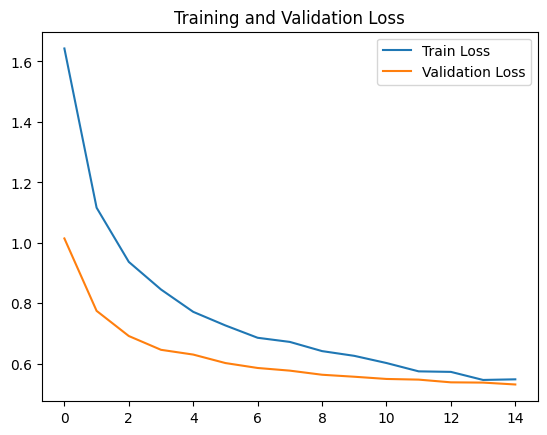

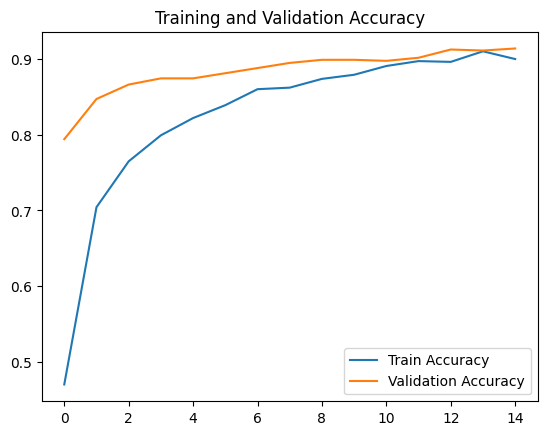

92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - accuracy: 0.9549 - loss: 0.4221
Train Accuracy: 95.50%
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.9138 - loss: 0.5402
Validation Accuracy: 91.42%


In [ ]:
import matplotlib.pyplot as plt

# Training loss vs Validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Training Accuracy vs Validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Evaluate model
loss, accuracy = model.evaluate(train_data)
print(f'Train Accuracy: {accuracy * 100:.2f}%')

val_loss, val_accuracy = model.evaluate(val_data)
print(f'Validation Accuracy: {val_accuracy*100:.2f}%')

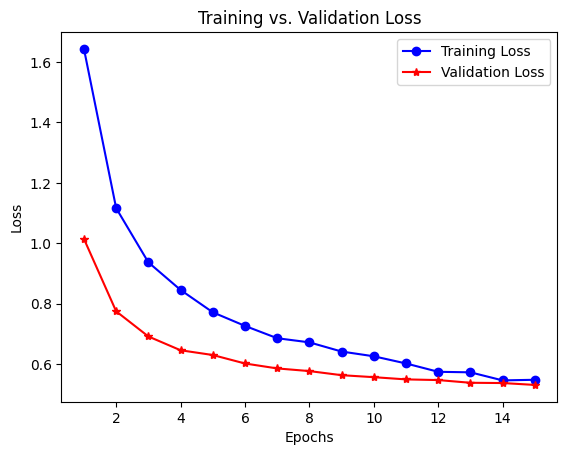

In [ ]:
import matplotlib.pyplot as plt

# Get loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plot loss
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.show()


Confusion matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


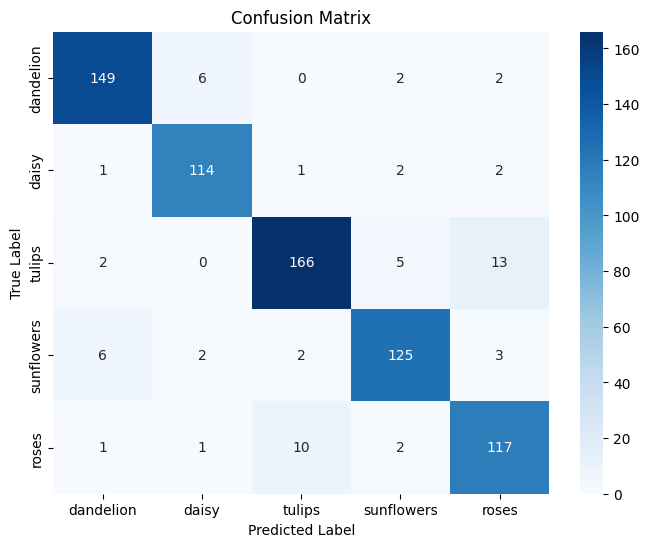

Classification Report:
               precision    recall  f1-score   support

       daisy       0.94      0.94      0.94       159
   dandelion       0.93      0.95      0.94       120
       roses       0.93      0.89      0.91       186
  sunflowers       0.92      0.91      0.91       138
      tulips       0.85      0.89      0.87       131

    accuracy                           0.91       734
   macro avg       0.91      0.92      0.91       734
weighted avg       0.91      0.91      0.91       734



In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# class in tf_flowers
class_name = ['daisy', 'dandelion','roses','sunflowers','tulips']

# Get true labels and predictions
y_true = []
y_pred = []


for images, labels in val_data:
    predictions = model.predict(images)  # Get predicted probabilities
    y_true.extend(labels.numpy())  # Store true labels
    y_pred.extend(np.argmax(predictions,axis=1))  # Convert probs to class labels using argmax
# grabs the index of the class with highest probability, for each image.

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred) #compares predictions vs. true labels.

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels = class_names, yticklabels = class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names = class_name))
#classification_report() — gives precision, recall, and F1-score per class


Creating an image batch and making predictions

In [ ]:
class_names = np.array(dataset_info.features['label'].names)
print(class_names)

['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

image_batch, label_batch = next(iter(train_data))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
print(predicted_class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
['tulips' 'sunflowers' 'sunflowers' 'roses' 'sunflowers' 'dandelion'
 'dandelion' 'dandelion' 'dandelion' 'daisy' 'sunflowers' 'tulips' 'roses'
 'daisy' 'tulips' 'daisy' 'daisy' 'tulips' 'sunflowers' 'sunflowers'
 'sunflowers' 'dandelion' 'roses' 'tulips' 'daisy' 'daisy' 'daisy'
 'sunflowers' 'roses' 'tulips' 'tulips' 'sunflowers']


Plot model predictions

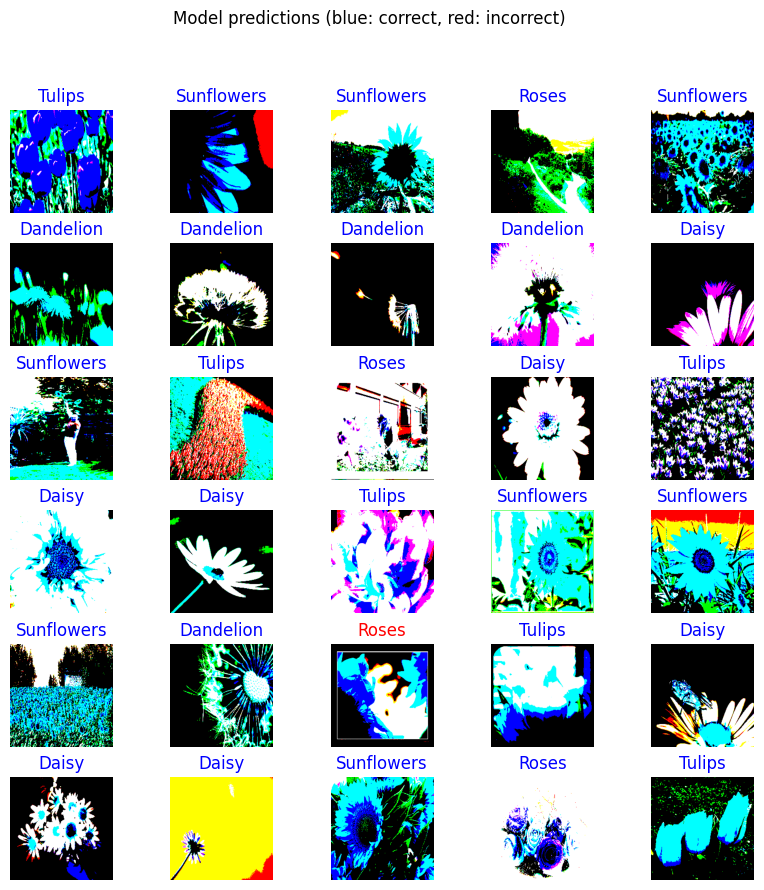

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace = 0.3)
    plt.imshow(image_batch[n])
    color = "blue" if predicted_ids[n] == label_batch[n] else "red"
    plt.title(predicted_class_names[n].title(), color=color)
    plt.axis('off')
    plt.suptitle("Model predictions (blue: correct, red: incorrect)")